# Visualizing the difference between the measurement setups

* v0_O0: debug measurement
* v1_O3: release O3 optimized measurement
* v2_O3: same meas as v1_O3, but code redownloaded
* v3_O3: same meas as v2_O3, started the meas immediately after
* v4_O3: meas after recompilation
* v5_O3, v6_O3, v7_O3: shuffled config list, then sorted based on cache and memory

### Visualizing the measured values for different base directories

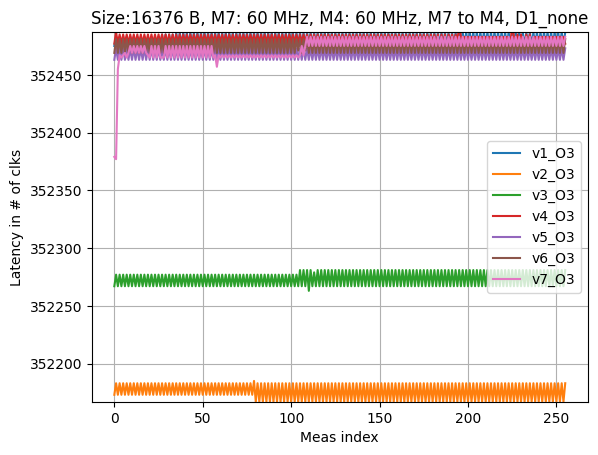

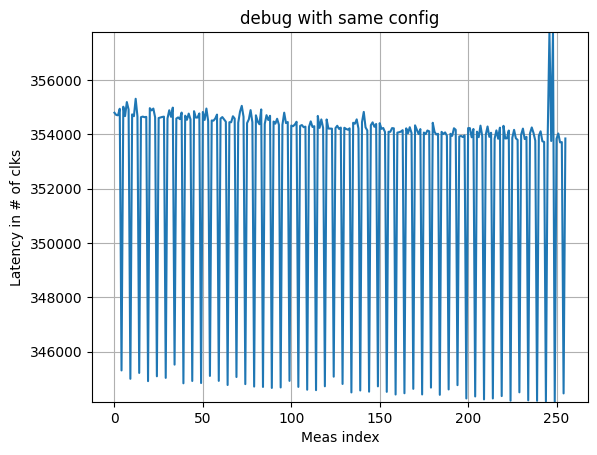

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import measurement as meas
from histogram import time_progression

base_dirs = ['v1_O3', 'v2_O3', 'v3_O3', 'v4_O3', 'v5_O3', 'v6_O3', 'v7_O3']
meas_configs = {
    'direction': ['s'],
    'clkM7': [60],
    'clkM4': [60],
    'repeat': [256],
    'datasize': [16376],
    'mem': ['D1'],
    'cache': ['none'],
}

conf = {k: meas_configs[k][0] for k in meas_configs}
dir_txt = 'M7 to M4' if conf['direction']=='s' else 'M4 to M7'
title = (f'Size:{conf["datasize"]} B, '
        f'M7: {conf["clkM7"]} MHz, '
        f'M4: {conf["clkM4"]} MHz, '
        f'{dir_txt}, '
        f'{conf["mem"]}_{conf["cache"]}')

plt.figure()
plt.title(title)
plt.ylabel('Latency in # of clks')
plt.xlabel('Meas index')

min, max = None, None
for base_dir in base_dirs:
    raw_list, _, conf_list = meas.read_meas_from_files(meas_configs,
                                                        base_dir)
    for raw, conf in zip(raw_list, conf_list):
        # histogram_intervals(raw, title)
        min = np.min(raw) if min is None else np.min((min, np.min(raw)))
        max = np.max(raw) if max is None else np.max((max, np.min(raw)))
        plt.plot(np.arange(len(raw)), raw)
plt.ylim(min, max)
plt.legend(base_dirs)
plt.grid()

plt.figure()
raw_list, _, conf_list = meas.read_meas_from_files(meas_configs, 'v0_O0')
for raw, conf in zip(raw_list, conf_list):
    time_progression(raw, 'debug with same config')
plt.show()

### Visualizing the different measurements with the plot displaying the change on size

After checking around 20 different set of parameters, the plot didn't show significant difference between the measurements in case of datarate

In case of latency there is some minor variation, also not significant

(When checking with cache enabled there seems to be less variation inbetween)

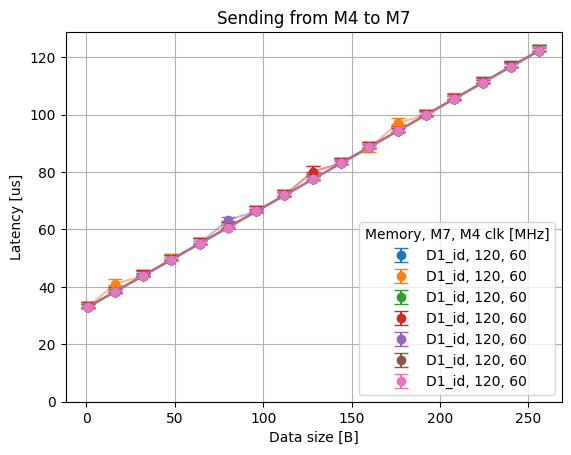

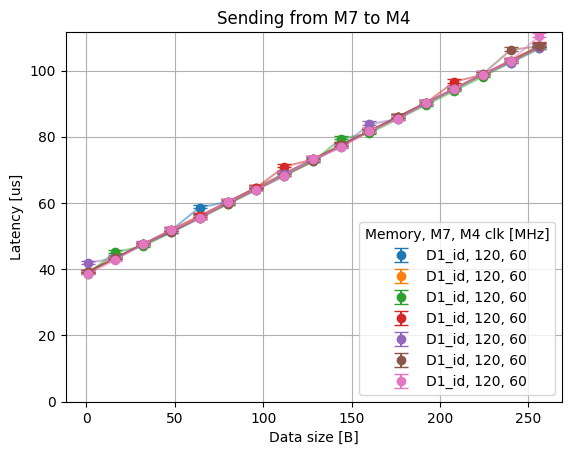

In [2]:
import matplotlib as mpl
from visu import errorbars, setup_errorbars
cmap = mpl.colormaps['tab10'].colors
sizes_short = [1] + [16*x for x in range(1, 17)]
sizes_long = ([1]
            + [16*x for x in range(1, 17)]
            + [512, 1024, 1536]
            + [1024*x for x in range(2, 16)] + [16376])
meas_configs = {
    'direction': ['r', 's'],
    'clkM7': [120],
    'clkM4': [60],
    'repeat': [256],
    'datasize': sizes_short,
    'mem': ['D1'],
    'cache': ['id'],
}
base_dirs = ['v1_O3', 'v2_O3', 'v3_O3', 'v4_O3', 'v5_O3', 'v6_O3', 'v7_O3']
meas_type = 'latency'

config_list = meas.config_to_config_list(meas_configs)
config_groups_list = meas.group_config_except(config_list, ['datasize'])
for direction in meas_configs['direction']:
    plt.figure()
    for i, base_dir in enumerate(base_dirs):
        config_groups = [cfg for cfg in config_groups_list 
                         if cfg['direction'] == direction]
        meas_datas = []
        for grouped_config in config_groups:
            ret, _ = meas.get_and_calc_meas(grouped_config, meas_type, base_dir)
            ret = meas.upper_lower_from_minmax(ret)
            meas_datas.append(ret)
        
        # list of configs and list of meas_values
        errorbars(config_groups, meas_configs['datasize'], meas_datas, cmap[i:])
        setup_errorbars(meas_type, direction)

# show graph
plt.show()